<a href="https://colab.research.google.com/github/mariewah/greiff-lab/blob/main/edit_vs_rmsd_(template).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install biopython
!pip install pylcs
import Bio.PDB

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 50.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for pylcs: filename=pylcs-0.0.8-cp310-cp310-linux_x86_64.whl size=1125478 sha256=0f109ec25f1ec694a96bc4716e467e8ec0e3216b1379bc90e1a77499b74ee199
  Stored in directory: /root/.cache/pip/wheels/b1/e8/5e/6f59ae9659e08741bef7f18f130e81fa82c3d9726449d5bf20
Successfully built pylcs


In [ ]:
import editdistance #ref: https://pypi.org/project/editdistance/0.3.1/
import pylcs #ref: https://pypi.org/project/pylcs/
from scipy.spatial import distance #ref: https://www.tutorialspoint.com/calculating-the-hamming-distance-using-scipy
import numpy as np
import sys
import pandas as pd
import re
import os

ref_seq = 'WGGDGFYAMD'
dir_path ='/content/drive/MyDrive/greiff/melis/'
file_name_list = os.listdir(dir_path)


FileNotFoundError: ignored

In [ ]:
heavy_lengths = []
aa_code_dict = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
                'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N',
                'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', #'AARG':'R', 'ACYS':'C',
                'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

In [ ]:
"""
reads the pdb and returns it as a dataframe, skips header lines

@return pandas dataframe table for pdb file
"""
def get_main_pdb():
    #for original abdb 96 skip
    skip_no = 96
    if file_name[0]=='t':
      skip_no = 3
    if file_name[0]=='u':
      skip_no = 0

    pdb_table = pd.read_table(file_path, delim_whitespace=True, skiprows = skip_no, header=None, names=['header', 'atom_no', 'atom','aa', 'chain', 'res','x','y','z','occup','b','a'])
    return pdb_table

In [ ]:
"""
returns 3-letter sequence of the heavy chain from pdb

@return int array of one letter amino acid codes
"""
def get_3letter_seq():
  pdb_table = get_main_pdb()
  only_heavy = pdb_table[pdb_table['chain']=='H']

  seq = pd.DataFrame()
  only_heavy['aa'] = [only_heavy['aa'][i][1:] if len(only_heavy['aa'][i]) == 4 else only_heavy['aa'][i] for i in range(len(only_heavy['aa']))]
  seq['code'] = only_heavy['res'].astype(str) + " " + only_heavy['aa']
  seq['amino_acid']= only_heavy['aa']

  seq = seq.drop_duplicates('code', keep='last') #to remove atom representations into residue

  #heavy_lengths.append(len(np.array(seq['amino_acid'])))

  return np.array(seq['amino_acid'])

In [ ]:

def get_one_letter_region(start,end):

  three_let_seq = get_3letter_seq()
  three_let_seq = three_let_seq#[start:end]
  #print(three_let_seq)

  one_let_seq = ""
  for let in three_let_seq:
    if len(let)==4:
      #one_let_seq.append(aa_code_dict[let[1:]])
      one_let_seq = one_let_seq + aa_code_dict[let[1:]]
    else:
      #one_let_seq.append(aa_code_dict[let])
      one_let_seq = one_let_seq + aa_code_dict[let]
  #if(len(one_let_seq)!=120):
    #print(str(len(one_let_seq)) + " " + file_name)
  #heavy_lengths.append(len(one_let_seq))
  return one_let_seq[start:end]

In [ ]:
!pip install igfold

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
"""
calculates rmsd over start and end residues for refeerence structure (1N8Z_1.pdb)
and the current modeled structure in the directory

@param int start_id    start residue
@param int end_id      end residue

@return float rmsd
"""
def calculate_rmsd(start_id, end_id):
  #code ref: https://gist.github.com/andersx/6354971

  # Start the parser
  pdb_parser = Bio.PDB.PDBParser(QUIET = True)

  ref_struc_name = "/content/drive/MyDrive/greiff/1N8Z_1.pdb"
  mut_struc_name = file_path

  # Get the structures
  ref_structure = pdb_parser.get_structure("reference", ref_struc_name)
  mut_structure = pdb_parser.get_structure("mutated", mut_struc_name)

  ref_model = ref_structure[0]
  mut_model = mut_structure[0]

  ref_atoms = []
  sample_atoms = []

  # Iterate of all chains in the model in order to find all residues
  for ref_chain in ref_model:
    #only getting heavy chain
    if(ref_chain.get_id()=='H'):
      for ref_res in ref_chain:
          ref_atoms.append(ref_res['CA'])

  # Do the same for the sample structure
  for sample_chain in mut_model:
    if(sample_chain.get_id()=='H'):
      for sample_res in sample_chain:
          sample_atoms.append(sample_res['CA'])


  #initiate the superimposer:
  super_imposer = Bio.PDB.Superimposer()
  super_imposer.set_atoms(ref_atoms[start_id:end_id], sample_atoms[start_id:end_id])
  super_imposer.apply(mut_model.get_atoms())

  #print(super_imposer.rms)
  return super_imposer.rms

In [ ]:
#def main():
from igfold import IgFoldRunner
global file_name
global file_path

edit_distances, LCSs, hammings, rmsds = [],[], [], []
abb_levinshtein, igfold_levinshtein = [], []
abb_lcs, igfold_lcs = [], []
abb_hamming, igfold_hamming = [], []
abb_rmsd, igfold_rmsd = [], []
#residues to be calculated over
start_pos = 98
end_pos = 108
PAM_scores = []
antiberty_embeds = []
igfold = IgFoldRunner()
#iterating over all files for abb and igfold
for file_name in file_name_list:
    if file_name[0]!='.': #skips .DS_store

    #update new struc
      file_path = dir_path + file_name
      seq = get_one_letter_region(start_pos,end_pos)


      sequences = {
      "H": ""+seq,
     #"L": "DVVMTQTPFSLPVSLGDQASISCRSSQSLVHSNGNTYLHWYLQKPGQSPKLLIYKVSNRFSGVPDRFSGSGSGTDFTLKISRVEAEDLGVYFCSQSTHVPYTFGGGTKLEIK"
      }


      emb = igfold.embed(
          sequences=sequences, # Antibody sequences
      )

      antiberty_embeds.append(emb.bert_embs) # Embeddings from AntiBERTy final hidden layer (dim: 1, L, 512)
        #blosum = MatrixInfo.pam250

        #PAM_scores.append(score_pairwise(seq, ref_seq, blosum, -5, -1))

"""
        levinshtein = editdistance.eval(get_one_letter_region(start_pos,end_pos), ref_seq)
        lcs = pylcs.lcs_sequence_length(get_one_letter_region(start_pos,end_pos), ref_seq)
        hamming = distance.hamming(list(get_one_letter_region(start_pos,end_pos)), list(ref_seq))*len(ref_seq)
        rmsd = calculate_rmsd(start_pos,end_pos)
        if file_name[0] == 't':
          abb_levinshtein.append(levinshtein)
          abb_lcs.append(lcs)
          abb_hamming.append(hamming)
          abb_rmsd.append(rmsd)
        else:
          igfold_levinshtein.append(levinshtein)
          igfold_lcs.append(lcs)
          igfold_rmsd.append(rmsd)
          igfold_hamming.append(hamming)

        edit_distances.append(levinshtein)
        LCSs.append(lcs)
        hammings.append(hamming)
        rmsds.append(rmsd)

print(edit_distances)
"""
#if __name__ == "__main__":
    #main()

No module named 'pyrosetta'

    The code, data, and weights for this work are made available for non-commercial use 
    (including at commercial entities) under the terms of the JHU Academic Software License 
    Agreement. For commercial inquiries, please contact jruffolo[at]jhu.edu.
    License: https://github.com/Graylab/IgFold/blob/main/LICENSE.md
    
Loading 4 IgFold models...
Using device: cpu
Loading /usr/local/lib/python3.7/dist-packages/igfold/trained_models/IgFold/igfold_1.ckpt...
Loading /usr/local/lib/python3.7/dist-packages/igfold/trained_models/IgFold/igfold_2.ckpt...
Loading /usr/local/lib/python3.7/dist-packages/igfold/trained_models/IgFold/igfold_3.ckpt...
Loading /usr/local/lib/python3.7/dist-packages/igfold/trained_models/IgFold/igfold_5.ckpt...
Successfully loaded 4 IgFold models.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Completed embedding in 0.31 seconds.
Completed embedding in 0.08 seconds.
Completed embedding in 0.09 seconds.
Completed embedding in 0.10 seconds.
Completed embedding in 0.08 seconds.
Completed embedding in 0.08 seconds.
Completed embedding in 0.08 seconds.
Completed embedding in 0.08 seconds.
Completed embedding in 0.08 seconds.
Completed embedding in 0.09 seconds.
Completed embedding in 0.09 seconds.
Completed embedding in 0.09 seconds.
Completed embedding in 0.09 seconds.
Completed embedding in 0.09 seconds.
Completed embedding in 0.09 seconds.
Completed embedding in 0.08 seconds.
Completed embedding in 0.10 seconds.
Completed embedding in 0.08 seconds.
Completed embedding in 0.20 seconds.
Completed embedding in 0.16 seconds.
Completed embedding in 0.08 seconds.
Completed embedding in 0.08 seconds.
Completed embedding in 0.09 seconds.
Completed embedding in 0.09 seconds.
Completed embedding in 0.09 seconds.
Completed embedding in 0.09 seconds.
Completed embedding in 0.09 seconds.
C

"\n        levinshtein = editdistance.eval(get_one_letter_region(start_pos,end_pos), ref_seq)\n        lcs = pylcs.lcs_sequence_length(get_one_letter_region(start_pos,end_pos), ref_seq)\n        hamming = distance.hamming(list(get_one_letter_region(start_pos,end_pos)), list(ref_seq))*len(ref_seq)\n        rmsd = calculate_rmsd(start_pos,end_pos)\n        if file_name[0] == 't':\n          abb_levinshtein.append(levinshtein)\n          abb_lcs.append(lcs)\n          abb_hamming.append(hamming)\n          abb_rmsd.append(rmsd)\n        else:\n          igfold_levinshtein.append(levinshtein)\n          igfold_lcs.append(lcs)\n          igfold_rmsd.append(rmsd)\n          igfold_hamming.append(hamming)\n\n        edit_distances.append(levinshtein)\n        LCSs.append(lcs)\n        hammings.append(hamming)\n        rmsds.append(rmsd)\n\nprint(edit_distances)\n"

In [ ]:
antiberty_embeds

[tensor([[[-1.9044, -0.8395, -2.2783,  ...,  0.4680,  0.3636,  0.7039],
          [-1.0242, -0.3713, -1.1670,  ...,  0.3438,  0.2617,  0.8457],
          [-2.1153, -1.0274, -1.6036,  ...,  0.5272,  0.7109, -0.2021],
          ...,
          [-0.5551, -1.2405, -1.8226,  ...,  0.6440, -0.5586,  0.2133],
          [-0.6552, -0.6860, -1.4717,  ..., -0.0609, -0.0465,  0.0161],
          [-0.9391, -0.8192, -1.8016,  ...,  0.0235,  0.3197, -0.3390]]],
        grad_fn=<CatBackward0>),
 tensor([[[-2.2216,  0.5536, -1.6688,  ...,  0.3118,  0.4756,  0.6673],
          [-0.8359,  0.4693, -1.4694,  ..., -0.1714,  0.0717, -0.4139],
          [-2.1271, -0.2879, -1.5112,  ...,  1.0196, -0.0818, -0.5399],
          ...,
          [-1.5536, -0.1554, -0.8399,  ...,  0.2306, -0.0124,  0.4136],
          [-0.4385, -0.3337, -1.5010,  ...,  0.4552,  0.3054,  0.1588],
          [-1.1233, -0.0311, -1.8737,  ..., -0.1552,  0.3692, -0.2949]]],
        grad_fn=<CatBackward0>),
 tensor([[[-1.6661, -0.7637, -3.3615

In [ ]:
np.squeeze(antiberty_embeds[1]).shape


torch.Size([10, 512])

In [ ]:
np.squeeze(antiberty_embeds[1]).detach().numpy()

In [ ]:
from scipy.spatial.distance import cosine
heatmap = np.zeros((len(antiberty_embeds),len(antiberty_embeds)))
print(heatmap.shape)
for embed1 in range(len(antiberty_embeds)):
  for embed2 in range(len(antiberty_embeds)):
    heatmap[embed1,embed2] = cosine(np.sum(np.squeeze(antiberty_embeds[embed1]).detach().numpy(),axis = 0), np.sum(np.squeeze(antiberty_embeds[embed2].detach().numpy()),axis = 0))

(1810, 1810)


ValueError: ignored

In [ ]:
sequences = {
  "H": ""+ref_seq,
    #"L": "DVVMTQTPFSLPVSLGDQASISCRSSQSLVHSNGNTYLHWYLQKPGQSPKLLIYKVSNRFSGVPDRFSGSGSGTDFTLKISRVEAEDLGVYFCSQSTHVPYTFGGGTKLEIK"
  }


emb_ref = igfold.embed(
    sequences=sequences, # Antibody sequences
)

ref_embed = emb_ref.bert_embs


Completed embedding in 0.22 seconds.


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [ ]:
antiberty_embeds = antiberty_embeds[:-1]

In [ ]:
len(antiberty_embeds)

1809

In [ ]:
dists = list()
for embed2 in range(len(antiberty_embeds)):
    dists.append(cosine(np.sum(np.squeeze(ref_embed).detach().numpy(),axis = 0), np.sum(np.squeeze(antiberty_embeds[embed2].detach().numpy()),axis = 0)))


(array([  1.,   0.,  10., 157., 627., 608., 281.,  94.,  22.,   9.]),
 array([0.        , 0.0778631 , 0.1557262 , 0.2335893 , 0.31145241,
        0.38931551, 0.46717861, 0.54504171, 0.62290481, 0.70076791,
        0.77863102]),
 <a list of 10 Patch objects>)

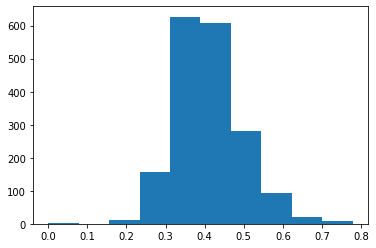

In [ ]:
plt.hist(dists)

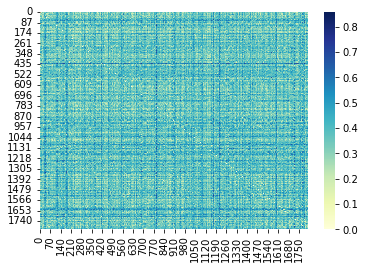

In [ ]:
# libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create a dataset
df = pd.DataFrame(heatmap)

# plot using a color palette
sns.heatmap(df, cmap="YlGnBu")
plt.show()

In [ ]:
from igfold import IgFoldRunner

sequences = {
    "H": "EVQLVQSGPEVKKPGTSVKVSCKASGFTFMSSAVQWVRQARGQRLEWIGWIVIGSGNTNYAQKFQERVTITRDMSTSTAYMELSSLRSEDTAVYYCAAPYCSSISCNDGFDIWGQGTMVTVS",
    "L": "DVVMTQTPFSLPVSLGDQASISCRSSQSLVHSNGNTYLHWYLQKPGQSPKLLIYKVSNRFSGVPDRFSGSGSGTDFTLKISRVEAEDLGVYFCSQSTHVPYTFGGGTKLEIK"
}

igfold = IgFoldRunner()
emb = igfold.embed(
    sequences=sequences, # Antibody sequences
)

emb.bert_embs # Embeddings from AntiBERTy final hidden layer (dim: 1, L, 512)

In [ ]:
emb.bert_embs.shape

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.scatter(np.sum(emb.bert_embs, out=float, axis =2))

In [ ]:
print(len(file_name_list))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def show_pairplot(data, rmsds, color):
  edit_vs_rmsd_df = pd.DataFrame()
  edit_vs_rmsd_df["edit"] = data
  edit_vs_rmsd_df["rmsd"] = rmsds
  # with regression
  sns.pairplot(edit_vs_rmsd_df, kind="reg", diag_kind='hist', plot_kws={'color':color}, diag_kws={'color':color})
  plt.show()




In [ ]:
show_pairplot(abb_levinshtein,abb_rmsd, 'green')

In [ ]:
#show_pairplot(igfold_levinsthein,igfold_rmsd,"purple")

In [ ]:
from Bio.Align import substitution_matrices
names = substitution_matrices.load()
names

In [ ]:
from Bio.SubsMat import MatrixInfo

def score_match(pair, matrix):
    if pair not in matrix:
        return matrix[(tuple(reversed(pair)))]
    else:
        return matrix[pair]

def score_pairwise(seq1, seq2, matrix, gap_s, gap_e):
    score = 0
    gap = False
    for i in range(len(seq1)):
        pair = (seq1[i], seq2[i])
        if not gap:
            if '-' in pair:
                gap = True
                score += gap_s
            else:
                score += score_match(pair, matrix)
        else:
            if '-' not in pair:
                gap = False
                score += score_match(pair, matrix)
            else:
                score += gap_e
    return score

seq1 = 'PAVKDLGAEG-ASDKGT--SHVVY----------TI-QLASTFE'
seq2 = 'PAVEDLGATG-ANDKGT--LYNIYARNTEGHPRSTV-QLGSTFE'

blosum = MatrixInfo.pam250

score_pairwise(seq1, seq2, blosum, -5, -1)

In [ ]:
lcs_vs_rmsd_df = pd.DataFrame()
lcs_vs_rmsd_df["lcs"] = LCSs
lcs_vs_rmsd_df["rmsd"] = rmsds
# with regression
sns.pairplot(lcs_vs_rmsd_df, kind="reg")
plt.show()


In [ ]:
LCSs
np.unique(LCSs, return_counts=True)

In [ ]:
distance.hamming(list("WDGAHSYDHD"), list(ref_seq))*len(ref_seq)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# plot
sns.regplot(x=edit_vs_rmsd_df["edit"], y=edit_vs_rmsd_df["rmsd"], line_kws={"color":"r","alpha":0.7,"lw":5})
plt.show()

In [ ]:
sns.jointplot(x=edit_vs_rmsd_df["edit"], y=edit_vs_rmsd_df["rmsd"], kind='scatter')

Validating RMSD calculation

In [ ]:
pdb_parser = Bio.PDB.PDBParser(QUIET = True)

ref_struc_name = "/content/drive/MyDrive/greiff/1N8Z_1.pdb"
mut_struc_name = "/content/drive/MyDrive/greiff/trastuzumab_hb_6_abb.pdb"

# Get the structures
ref_structure = pdb_parser.get_structure("reference", ref_struc_name)
mut_structure = pdb_parser.get_structure("mutated", mut_struc_name)

ref_model = ref_structure[0]
mut_model = mut_structure[0]

ref_atoms = []
sample_atoms = []

# Iterate of all chains in the model in order to find all residues
for ref_chain in ref_model:
  #only getting heavy chain
  if(ref_chain.get_id()=='H'):
      for ref_res in ref_chain:
          ref_atoms.append(ref_res['CA'])

  # Do the same for the sample structure
for sample_chain in mut_model:
  if(sample_chain.get_id()=='H'):
      for sample_res in sample_chain:
          sample_atoms.append(sample_res['CA'])


  #initiate the superimposer:
super_imposer = Bio.PDB.Superimposer()
super_imposer.set_atoms(ref_atoms[98:108], sample_atoms[98:108])
super_imposer.apply(mut_model.get_atoms())
super_imposer.rms

In [ ]:
print(max(heavy_lengths))
print(min(heavy_lengths))

In [ ]:
heavy_lengths


In [ ]:
plt.hist(heavy_lengths)

In [ ]:
seq = "EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLEWVARIYPTNGYTRYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCSRWGGDGFYAMDYWGQGTLVTVSSA"
len(seq)

In [ ]:
t_lb_4256 = "EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLEWVARIYPTNGYTRYADSVKGRFTISADSKNTAYLQMNSLRAEDTAVYYCSRYSVSGFDPYMYWGQGTLVTVSS"
len(t_lb_4256)

my_t_lb_4256 = "EVQLVESGGGLVQPGGSSLRLSCAASGFNIKDTYIHWVRQAPGKGLEWVARIYPTNGYTRYADSVKGRFTISADTTSKNTAYLQMNSLRAEDTAVYYCCSRYSVSGFDPYMYWGQGTLVTVSS"
len(my_t_lb_4256)

In [ ]:
pip install antiberty==0.0.5

In [ ]:
from antiberty import AntiBERTy, get_weights

antiberty = AntiBERTy.from_pretrained(get_weights())
antiberty.